## Final Project - Haejin Cho(hcho435)

In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import pytensor.tensor as pt
import typing

### Data Exploration

In [2]:
# Load the dataset
user1_df = pd.read_csv("./data/warp_data_user1.csv")
user2_df = pd.read_csv("./data/warp_data_user2.csv")
user3_df = pd.read_csv("./data/warp_data_user3_whale.csv", skiprows=1)

In [3]:
# we are only interested in type 11; user3 data only contains type 11
user1_df = user1_df[user1_df["type"] == 11]
user2_df = user2_df[user2_df["type"] == 11]

In [4]:
user1_df.head()

,uid,id,rarity,time,banner,type,manual
47,1731615000000035973,20007,3,2024-11-14T20:14:29.000Z,2049,11,False
48,1731615000000036073,20008,3,2024-11-14T20:14:29.000Z,2049,11,False
49,1731615000000036173,21046,4,2024-11-14T20:14:29.000Z,2049,11,False
50,1731615000000036273,1108,4,2024-11-14T20:14:29.000Z,2049,11,False
51,1731615000000036373,20019,3,2024-11-14T20:14:29.000Z,2049,11,False


In [5]:
user2_df.head()

,uid,id,rarity,time,banner,type,manual
92,1731550200000153622,20018,3,2024-11-14T02:15:35.000Z,2050,11,False
93,1731550200000153722,20009,3,2024-11-14T02:15:35.000Z,2050,11,False
94,1731550200000153822,20018,3,2024-11-14T02:15:35.000Z,2050,11,False
95,1731550200000153922,20019,3,2024-11-14T02:15:35.000Z,2050,11,False
96,1731550200000154022,20001,3,2024-11-14T02:15:35.000Z,2050,11,False


In [6]:
user3_df.head()

,uid,pull_number,rarity,type,did_win_featured,eidolon,pity_counter,pity_counter_featured
0,user3_pull1,1,3,11,NaN,NaN,1,1
1,user3_pull2,2,4,11,NaN,NaN,2,2
2,user3_pull3,3,3,11,NaN,NaN,3,3
3,user3_pull4,4,3,11,NaN,NaN,4,4
4,user3_pull5,5,3,11,NaN,NaN,5,5


In [7]:
# basic statistics
print(f"User1's total number of character pulls: {len(user1_df)}")
print(f"User2's total number of character pulls: {len(user2_df)}")
print(f"User3's total number of character pulls: {len(user3_df)}")

User1's total number of character pulls: 190
User2's total number of character pulls: 368
User3's total number of character pulls: 580


In [8]:
# the number of pulls results for each rarity
user1_df[["rarity", "uid"]].groupby(["rarity"]).count()

,uid
rarity,
3,162
4,25
5,3


In [9]:
user2_df[["rarity", "uid"]].groupby(["rarity"]).count()

,uid
rarity,
3,315
4,47
5,6


In [10]:
user2_df[["rarity", "uid"]].groupby(["rarity"]).count()

,uid
rarity,
3,315
4,47
5,6


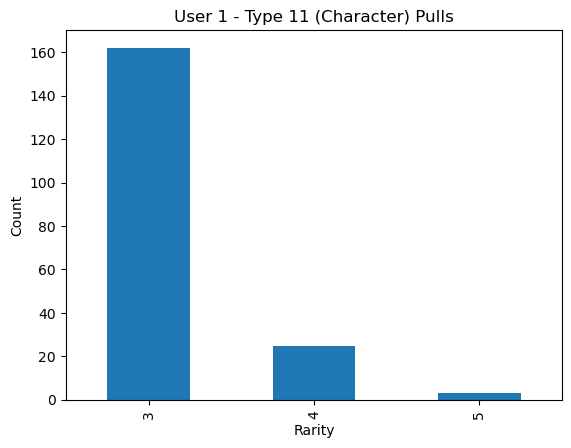

In [11]:
# distribution of the observed data
user1_df["rarity"].value_counts().plot(
    kind="bar",
    title="User 1 - Type 11 (Character) Pulls",
    xlabel="Rarity",
    ylabel="Count",
)
plt.show()

In [12]:
# the probability of observing each rarity
pd.DataFrame(user1_df[["rarity"]].value_counts(normalize=True))

,proportion
rarity,
3,0.852632
4,0.131579
5,0.015789


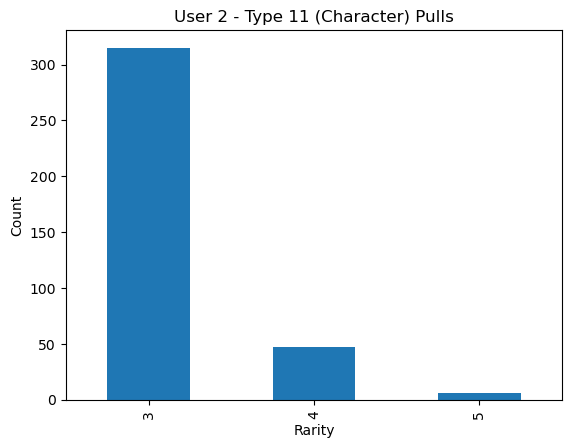

In [13]:
user2_df["rarity"].value_counts().plot(
    kind="bar",
    title="User 2 - Type 11 (Character) Pulls",
    xlabel="Rarity",
    ylabel="Count",
)
plt.show()

In [14]:
# the probability of observing each rarity
pd.DataFrame(user2_df[["rarity"]].value_counts(normalize=True))

,proportion
rarity,
3,0.855978
4,0.127717
5,0.016304


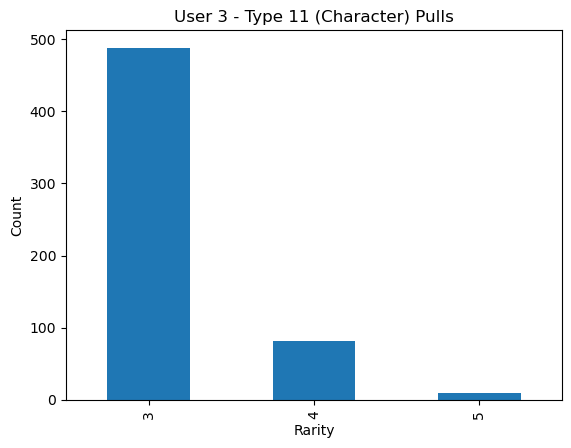

In [15]:
user3_df["rarity"].value_counts().plot(
    kind="bar",
    title="User 3 - Type 11 (Character) Pulls",
    xlabel="Rarity",
    ylabel="Count",
)
plt.show()

In [36]:
pd.DataFrame(user3_df[["rarity"]].value_counts())

,count
rarity,
3,488
4,82
5,10


In [16]:
# the probability of observing each rarity
pd.DataFrame(user3_df[["rarity"]].value_counts(normalize=True))

,proportion
rarity,
3,0.841379
4,0.141379
5,0.017241


In [17]:
# empirical distribution of the observed data
# x axis is the trial 
# y axis is the probability of observing each rarity
# and once 5 star is observed, the rest of the trials are ignored
user3_df.head(30)

,uid,pull_number,rarity,type,did_win_featured,eidolon,pity_counter,pity_counter_featured
0,user3_pull1,1,3,11,NaN,NaN,1,1
1,user3_pull2,2,4,11,NaN,NaN,2,2
2,user3_pull3,3,3,11,NaN,NaN,3,3
3,user3_pull4,4,3,11,NaN,NaN,4,4
4,user3_pull5,5,3,11,NaN,NaN,5,5
5,user3_pull6,6,3,11,NaN,NaN,6,6
6,user3_pull7,7,3,11,NaN,NaN,7,7
7,user3_pull8,8,3,11,NaN,NaN,8,8
8,user3_pull9,9,3,11,NaN,NaN,9,9
9,user3_pull10,10,3,11,NaN,NaN,10,10


In [18]:
user3_df[user3_df.rarity == 5]

,uid,pull_number,rarity,type,did_win_featured,eidolon,pity_counter,pity_counter_featured
12,user3_pull13,13,5,11,win,e0,13,13
52,user3_pull53,53,5,11,lose,e0,40,40
127,user3_pull128,128,5,11,guaranteed,e1,75,115
133,user3_pull134,134,5,11,lose,e1,6,6
209,user3_pull210,210,5,11,guaranteed,e2,76,82
287,user3_pull288,288,5,11,win,e3,78,78
348,user3_pull349,349,5,11,win,e4,61,61
422,user3_pull423,423,5,11,win,e5,74,74
497,user3_pull498,498,5,11,lose,e5,75,75
576,user3_pull577,577,5,11,guaranteed,e6,79,154


In [20]:
user3_df[user3_df.rarity == 5].pity_counter.values

array([13, 40, 75,  6, 76, 78, 61, 74, 75, 79])

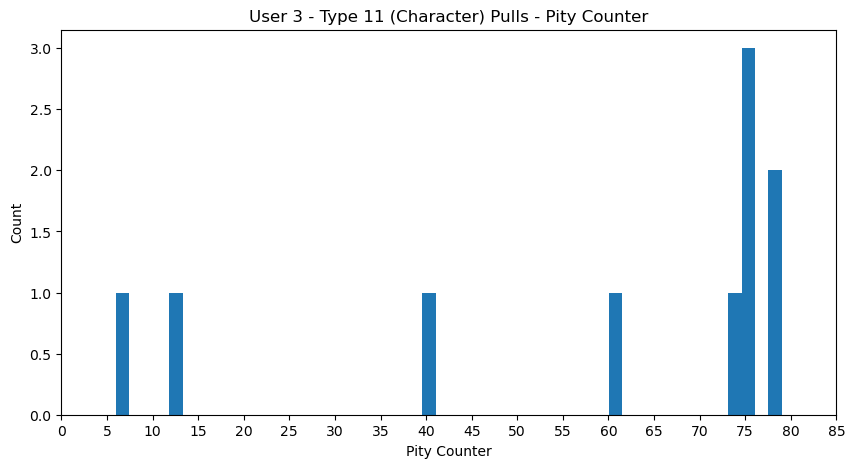

In [21]:
# pity count for rarity 5
user3_df[user3_df.rarity == 5].pity_counter.plot(
    kind="hist",
    title="User 3 - Type 11 (Character) Pulls - Pity Counter",
    xlabel="Pity Counter",
    ylabel="Count",
    bins=50,
    xticks=np.arange(0, 90, 5),
    figsize=(10, 5),
)
plt.show()

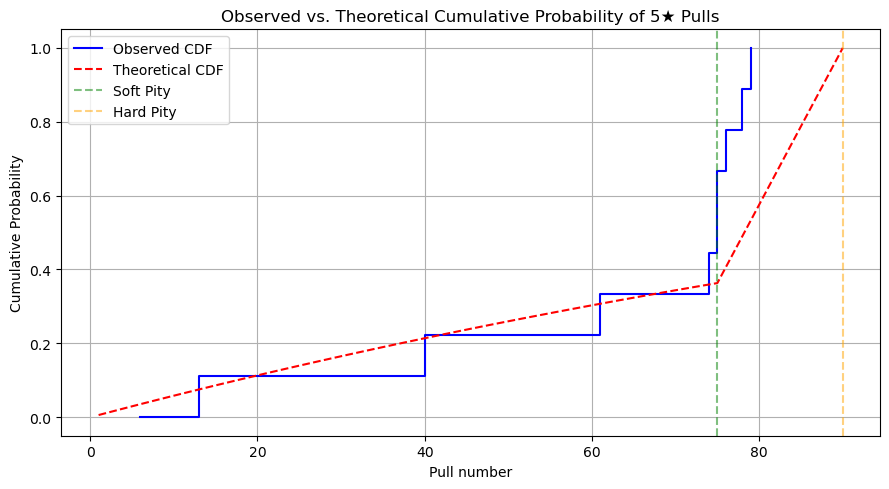

In [23]:
five_star_df = user3_df[user3_df["rarity"] == 5]
pity_counts = five_star_df["pity_counter"].sort_values().reset_index(drop=True)
percentiles = np.linspace(0, 1, len(pity_counts), endpoint=True)

x = np.arange(1, 91)
y = np.zeros_like(x, dtype=float)

# Define the probability behavior
base_rate = 0.006  # 0.6%
boosted_start = 75 # this is where the soft pity starts
boosted_end = 90   # this is where the hard pity ends

# First 74 pulls with constant 0.6% chance 
y[:boosted_start] = 1 - (1 - base_rate) ** x[:boosted_start]

# We know that the probability from the 75th pull to the 90th pull doesn't increase linearly, 
# but let's assume that here for now.
start_prob = y[boosted_start - 1]
y[boosted_start - 1:] = np.linspace(start_prob, 1.0, len(x[boosted_start - 1:]))

plt.figure(figsize=(9, 5))
plt.step(pity_counts, percentiles, where="post", label="Observed CDF", color="blue")
plt.plot(x, y, label="Theoretical CDF", color="red", linestyle="--")

# add vertical lines for the soft pity and hard pity
plt.axvline(x=boosted_start, color='green', linestyle='--', label='Soft Pity', alpha=0.5)
plt.axvline(x=boosted_end, color='orange', linestyle='--', label='Hard Pity', alpha=0.5)

plt.xlabel("Pull number")
plt.ylabel("Cumulative Probability")
plt.title("Observed vs. Theoretical Cumulative Probability of 5★ Pulls")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

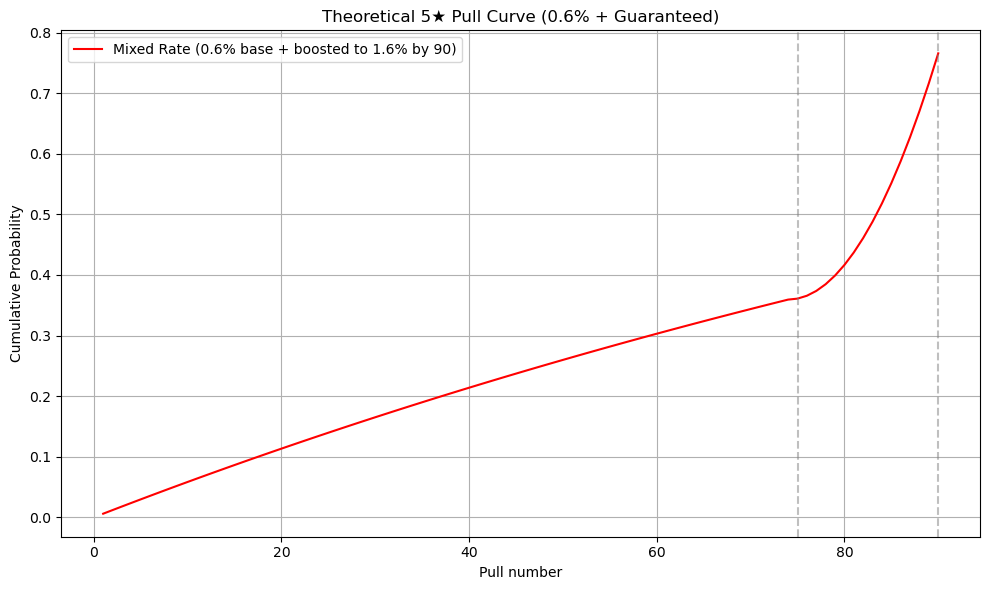

In [24]:
# First, create the cumulative probability line that:
# - Uses a flat 0.6% rate for pulls 1–74
# - Adjusts pulls 75–90 so that final cumulative probability equals the consolidated rate

# Base pull range
x = np.arange(1, 91)
y = np.zeros_like(x, dtype=float)

# Base rate and consolidated target
base_rate = 0.006
target_rate = 0.016

# First 74 pulls: cumulative probability using base rate
y[:74] = 1 - (1 - base_rate) ** x[:74]

# Calculate required cumulative probability at pull 90 using consolidated rate
target_cum_prob = 1 - (1 - target_rate) ** 90

# We need to smoothly increase from y[73] to target_cum_prob over pulls 74–89 (i.e., indices 74 to 89)
remaining_range = x[73:]  # pulls 74 to 90
num_points = len(remaining_range)

# Use a power curve to smoothly increase from y[73] to target (e.g., quadratic)
# A more realistic form than linear
start = y[73]
end = target_cum_prob
power_curve = np.linspace(0, 1, num_points)
y[73:] = start + (end - start) * power_curve**2  # quadratic ease-in

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, label="Mixed Rate (0.6% base + boosted to 1.6% by 90)", color='red')

plt.xlabel("Pull number")
plt.ylabel("Cumulative Probability")
plt.title("Theoretical 5★ Pull Curve (0.6% + Guaranteed)")
plt.axvline(75, color='gray', linestyle='--', alpha=0.5)
plt.axvline(90, color='gray', linestyle='--', alpha=0.5)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Bayesian Models

* Beta likelihood:
    * priors: $\alpha$, $\beta$
    * How to choose a prior distribution for these parameters?
* Student's t likelihood:
    * priors: $\nu$, $\mu$, $\sigma$
    * How to choose a prior distribution for these again?

In [160]:
cleaned_df = user3_df.copy()
cleaned_df["is_win"] = (cleaned_df["rarity"] == 5).astype(int)
cleaned_df = cleaned_df[["pull_number", "rarity", "is_win", "pity_counter"]]
cleaned_df.head()

,pull_number,rarity,is_win,pity_counter
0,1,3,0,1
1,2,4,0,2
2,3,3,0,3
3,4,3,0,4
4,5,3,0,5


In [112]:
loo_scores = {}

In [ ]:
with pm.Model() as m:
    # Prior: non-informative or weakly informative
    p = pm.Beta("p", alpha=1, beta=1)  # Uniform prior on win rate

    # Likelihood: Bernoulli per-pull
    y = pm.Bernoulli("y", p=p, observed=cleaned_df["is_win"])

    # Posterior sampling
    trace = pm.sample(10000, tune=1000, return_inferencedata=True, idata_kwargs={"log_likelihood": True})
    loo_scores["beta_bernoulli"] = az.loo(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 2 seconds.


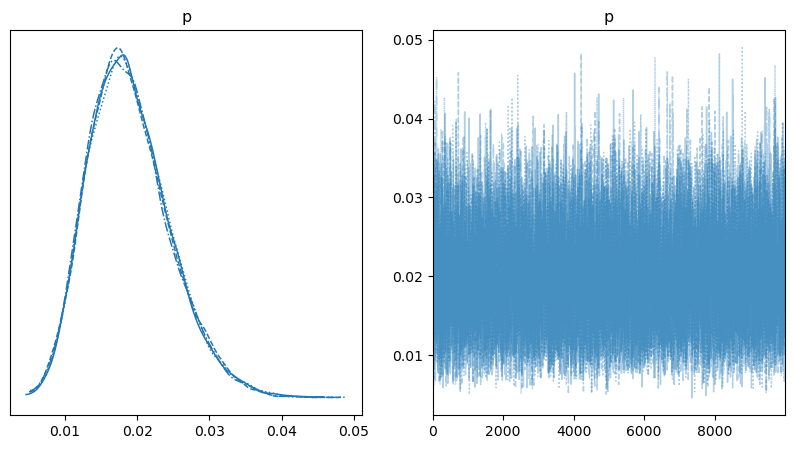

In [114]:
az.plot_trace(trace, var_names=["p"], figsize=(10, 5))
plt.show()

In [116]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.019,0.006,0.009,0.03,0.0,0.0,15536.0,20828.0,1.0


In [117]:
# Step: calculate number of pulls between each win
pull_indices = cleaned_df[cleaned_df["is_win"] == 1].index.to_numpy()
pull_gaps = np.diff(pull_indices)

with pm.Model() as m_student:
    mu = pm.Normal("mu", mu=50, sigma=50)
    sigma = pm.HalfNormal("sigma", sigma=20)
    nu = 1

    # deterministic variable for the probability of pulling a 5-star character
    p = pm.Deterministic("p", 1 - pm.math.exp(-1 / mu))

    # likelihood
    y = pm.StudentT("y", mu=mu, sigma=sigma, nu=nu, observed=pull_gaps)

    # sample
    trace_student = pm.sample(10000, tune=1000, cores=1, return_inferencedata=True, idata_kwargs={"log_likelihood": True})
    loo_scores["student_t"] = az.loo(trace_student)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu, sigma]


Output()

Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 4 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


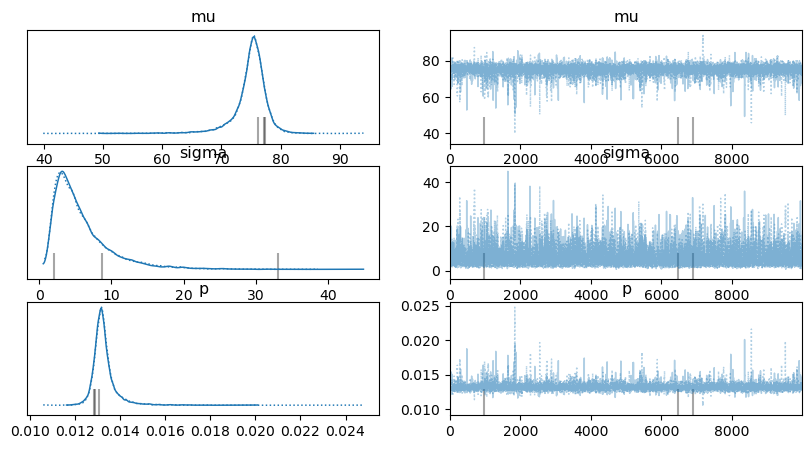

In [118]:
az.plot_trace(trace_student, var_names=["mu", "sigma", "p"], figsize=(10, 5))
plt.show()

In [119]:
az.summary(trace_student)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,74.901,2.992,69.223,79.436,0.051,0.036,5535.0,3502.0,1.0
sigma,5.852,4.049,0.885,13.161,0.058,0.041,5064.0,6654.0,1.0
p,0.013,0.001,0.012,0.014,0.000,0.000,5535.0,3502.0,1.0


In [120]:
print(loo_scores["beta_bernoulli"])

Computed from 40000 posterior samples and 580 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -51.53    12.67
p_loo        0.96        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      580  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [121]:
print(loo_scores["student_t"])

Computed from 20000 posterior samples and 9 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -39.51     5.53
p_loo        3.11        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        9  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



So student's T looks better? > but then it is not exactly the fair comparison. Maybe I could use Bayesian R2.

* What model is better, student's T or Beta-Bernouilli? >> Use LOO scores
* Can we find out that user1 and user2 are particularly lucky? >> Fit Test?
* The true probability is 1.6%. How to fine-tune our model to estimate that?
    * Maybe I need to find a prior rate using the known developer's rate? But then what's the purpose of this analysis? Like, we can estimate the shape of the distribution?
* How can we make "let data speak for itself"
* Can we make prediction for someone who has x amount of pity, pulling a 5 star character?
* Can we incorporate 50/50 winnings in the model and what's the final probability of pulling a desired 5 star character?

* Likelihood selection >> Based on AIC scores, you can decide which likelihood fits the data the best. Lower the better.
* Hurdle distributions? Since it's a extremely left-skewed data.

In [140]:
# Precompute the increasing range: linspace from 0.006 to 1 for x=75 to 80
increase_array = pt.as_tensor_variable(np.linspace(0.006, 1.0, 6).astype("float32"))

def custom_likelihood(x):
    index = pt.clip(x - 75, 0, 5)
    p = pt.switch(
        pt.le(x, 0),
        0.0,
        pt.switch(
            pt.lt(x, 75),
            0.006,
            pt.switch(
                pt.le(x, 80),
                increase_array[index],
                pt.switch(
                    pt.le(x, 90),
                    pt.exp(-0.7 * (x - 80)),
                    0.0
                )
            )
        )
    )
    return pt.log(p + 1e-9)  # log-probability for Potential

In [141]:
with pm.Model() as model_custom:
    pull = pm.DiscreteUniform("pull", lower=1, upper=100)
    pm.Potential("custom_likelihood", custom_likelihood(pull))
    p = pm.Deterministic("p", 1 - pm.math.exp(-1 / pull))

    # sample from the posterior
    trace_custom = pm.sample(10000, tune=1000, return_inferencedata=True)


Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [pull]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 2 seconds.


In [143]:
az.summary(trace_custom)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pull,75.058,14.797,40.000,86.000,0.639,0.452,1216.0,707.0,1.01
p,0.017,0.031,0.011,0.024,0.001,0.001,1216.0,720.0,1.00


In [144]:
# different model

# Turn the increasing segment into a tensor
increase_array = pt.as_tensor_variable(np.linspace(0.006, 1.0, 6).astype("float32"))

# Custom likelihood as a function of symbolic inputs
def custom_likelihood_param(pull, slope):
    index = pt.clip(pull - 75, 0, 5)

    p = pt.switch(
        pt.le(pull, 0),
        0.0,
        pt.switch(
            pt.lt(pull, 75),
            0.006,
            pt.switch(
                pt.le(pull, 80),
                increase_array[index],
                pt.switch(
                    pt.le(pull, 90),
                    pt.exp(-slope * (pull - 80)),
                    0.0
                )
            )
        )
    )
    return pt.log(p + 1e-9)  # log-likelihood


In [ ]:
with pm.Model() as model:
    # This is the parameter you want to estimate
    slope = pm.HalfNormal("slope", sigma=1.0)
    
    # Observed pulls from your data
    pull_obs = pm.Data("pull", cleaned_df["pull_number"].values)

    # Add the custom likelihood to the model
    pm.Potential("custom_likelihood", custom_likelihood_param(pull_obs, slope))
    pm.Deterministic("p", 1 - pm.math.exp(-1 / pull_obs))

    # Sample from posterior
    trace = pm.sample(1000, tune=1000, return_inferencedata=True)


TypeError: Potential() got an unexpected keyword argument 'shape'

In [151]:
az.summary(trace, var_names=["p"])["mean"].mean()

/Users/haejin.cho/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


0.010836206896551726

Using Geometric distribution

In [ ]:
with pm.Model() as model_geo:
    p = pm.Beta("p", alpha=1, beta=1)

    # likelihood for the number of pulls until the first success
    pull_number = pm.Geometric("pull_number", p=p, observed=cleaned_df[cleaned_df.is_win == 1].pity_counter.values)

    trace_geo = pm.sample(1000, tune=1000, return_inferencedata=True)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


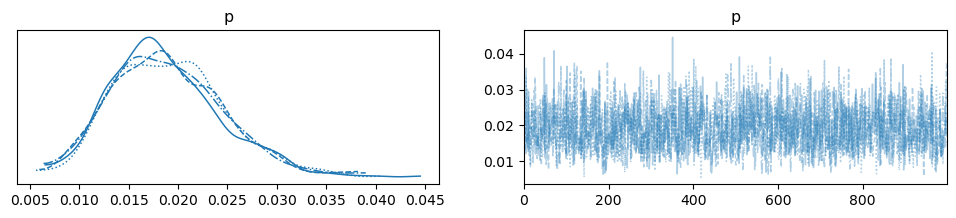

In [201]:
az.plot_trace(trace_geo, var_names=["p"])
plt.show()

In [196]:
az.summary(trace_geo)

/Users/haejin.cho/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.019,0.006,0.009,0.03,0.0,0.0,1629.0,2329.0,1.0
pull[0],13.000,0.000,13.000,13.00,0.0,0.0,4000.0,4000.0,NaN
pull[1],40.000,0.000,40.000,40.00,0.0,0.0,4000.0,4000.0,NaN
pull[2],75.000,0.000,75.000,75.00,0.0,0.0,4000.0,4000.0,NaN
pull[3],6.000,0.000,6.000,6.00,0.0,0.0,4000.0,4000.0,NaN
pull[4],76.000,0.000,76.000,76.00,0.0,0.0,4000.0,4000.0,NaN
pull[5],78.000,0.000,78.000,78.00,0.0,0.0,4000.0,4000.0,NaN
pull[6],61.000,0.000,61.000,61.00,0.0,0.0,4000.0,4000.0,NaN
pull[7],74.000,0.000,74.000,74.00,0.0,0.0,4000.0,4000.0,NaN
pull[8],75.000,0.000,75.000,75.00,0.0,0.0,4000.0,4000.0,NaN


#### Likelihood comparsions
- How to find the correct likelihood for the given data?
- Drawing histogram and visually inspect.
- You don't have the "known" scenarios (wait time, coin flips, ....)
- And definitely you don't think it's gonna be the normal distribution....
- **we have to find some criteria to choose likelihood for your data.**
- Quantile estimation -> refer to metalog paper (sometimes you can use type1, type2, ... and type3).
- Can we implement SPT parameterization to esitmate the p10 p50 and p90 of "pity count" of 5 star? (Like p10 = 10, p50 = 74, p90 = 78)


##### Hypothesis comparison: user1 claims that they are luckier than user2 because they go through a series of ritual before pulling gacha. Is that true?